# Rule revision analysis notebook

Code for analysis of rule making histories on 5 language editions. This code replicates the analyses in Keegan & Fiesler (2017) and adapts / directly uses code generously shared by Brian Keegan.

Put together by Sohyeon Hwang, 2020.

In [1]:
import argparse
import re, random, urllib, simplejson, copy, itertools
import urllib.parse, urllib.request, urllib.error
from datetime import datetime
# urllib.parse, urllib.request and urllib.error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')

import requests, json, time, os
from pathlib import Path

import networkx as nx
from operator import itemgetter
from collections import Counter
from bs4 import BeautifulSoup

import wikifunctions as wf

from multiprocessing import Pool, Manager, Process, cpu_count
from functools import partial

In [2]:
# helpful nuggets
"""
Subject Talk    Name        Description
0       1       Main        Articles, lists, & redirects
2       3       User        User pages & sandboxes
4       5       Wikipedia   Policy, essay, & processes
-6       7       File        Media file descriptions
-8       9       MediaWiki   Auto-generated pages
10      11      Template    Infoboxes, nav boxes
-12      13      Help        Software help
14      15      Category    Categorized pages
100     101     Portal      Topics & WikiProjects
"""
langs = ["de","en","es","fr","ja"]
namespaces = [0, 1, 2, 3, 4, 5, 10, 11, 14, 15, 100, 101]

## Load data
- list of rules
- all revisions for rule / rule talk pages
- all users, top users
    - all of their revisions to the rule pages (subset from all revisions)
- all bots, top bots
    - all of their revisions to the rule pages (subset from all revisions)
- all ip editors, top ip editors
    - all of their revisions to the rule pages (subset from all revisions)

In [3]:
# list of rules
rules_df_es = pd.read_csv(Path(os.getcwd()) / "dewiki.tsv",sep="\t",header=None)
rules_df_en = pd.read_csv(Path(os.getcwd()) / "enwiki.tsv",sep="\t",header=None)
rules_df_es = pd.read_csv(Path(os.getcwd()) / "eswiki.tsv",sep="\t",header=None)
rules_df_fr = pd.read_csv(Path(os.getcwd()) / "frwiki.tsv",sep="\t",header=None)
rules_df_ja = pd.read_csv(Path(os.getcwd()) / "jawiki.tsv",sep="\t",header=None)
rules_dfs = [rules_df_es,rules_df_en,rules_df_es,rules_df_fr,rules_df_ja]

In [4]:
# page revision histories
rev_path = Path(os.getcwd()) / "output_rulepagerevs" / "2020-07-31"

rev_df_de = pd.read_csv( rev_path / "de_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_en = pd.read_csv( rev_path / "en_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_es = pd.read_csv( rev_path / "es_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_fr = pd.read_csv( rev_path / "fr_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_ja = pd.read_csv( rev_path / "ja_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])

In [5]:
# talk page revision histories
talkrev_df_de = pd.read_csv( rev_path / "de_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_en = pd.read_csv( rev_path / "en_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_es = pd.read_csv( rev_path / "es_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_fr = pd.read_csv( rev_path / "fr_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_ja = pd.read_csv( rev_path / "ja_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)

In [6]:
# get rid of duplicate revisions for each language edition
rev_df_de.drop_duplicates(subset=['revid'],inplace=True)
rev_df_en.drop_duplicates(subset=['revid'],inplace=True)
rev_df_es.drop_duplicates(subset=['revid'],inplace=True)
rev_df_fr.drop_duplicates(subset=['revid'],inplace=True)
rev_df_ja.drop_duplicates(subset=['revid'],inplace=True)

talkrev_df_de.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_en.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_es.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_fr.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_ja.drop_duplicates(subset=['revid'],inplace=True)

In [7]:
# various user infos, name redirect files
cleaned_userinfo_de = pd.read_csv( 'user_info_de.csv',header=0,index_col=0,encoding='utf8' )
cleaned_userinfo_en = pd.read_csv( 'user_info_en.csv',header=0,index_col=0,encoding='utf8' )
cleaned_userinfo_es = pd.read_csv( 'user_info_es.csv',header=0,index_col=0,encoding='utf8' )
cleaned_userinfo_fr = pd.read_csv( 'user_info_fr.csv',header=0,index_col=0,encoding='utf8' )
cleaned_userinfo_ja = pd.read_csv( 'user_info_ja.csv',header=0,index_col=0,encoding='utf8' )

In [8]:
top_users_de = pd.read_csv( 'top_users_de.tsv',sep='\t',header=0,encoding='utf8',parse_dates=['ts_min','ts_max'],low_memory=False )
top_users_en = pd.read_csv( 'top_users_en.tsv',sep='\t',header=0,encoding='utf8',parse_dates=['ts_min','ts_max'],low_memory=False )
top_users_es = pd.read_csv( 'top_users_es.tsv',sep='\t',header=0,encoding='utf8',parse_dates=['ts_min','ts_max'],low_memory=False )
top_users_fr = pd.read_csv( 'top_users_fr.tsv',sep='\t',header=0,encoding='utf8',parse_dates=['ts_min','ts_max'],low_memory=False )
top_users_ja = pd.read_csv( 'top_users_ja.tsv',sep='\t',header=0,encoding='utf8',parse_dates=['ts_min','ts_max'],low_memory=False )

In [9]:
with open('name_redirects_de.json') as f:
    name_redirects_de = json.load(f)
with open('name_redirects_en.json') as f:
    name_redirect_en = json.load(f)
with open('name_redirects_es.json') as f:
    name_redirects_es = json.load(f)
with open('name_redirects_fr.json') as f:
    name_redirects_fr = json.load(f)
with open('name_redirects_ja.json') as f:
    name_redirects_ja = json.load(f)

In [10]:
#user start revisions
#user_start_rev_df_es = pd.read_csv('user_start_revisions_es.tsv',sep='\t',encoding='utf8',header=0,index_col=0,parse_dates=['date','timestamp'])
#user_start_rev_df_fr = pd.read_csv('user_start_revisions_fr.tsv',sep='\t',encoding='utf8',header=0,index_col=0,parse_dates=['date','timestamp'])
#user_start_rev_df_ja = pd.read_csv('user_start_revisions_ja.tsv',sep='\t',encoding='utf8',header=0,index_col=0,parse_dates=['date','timestamp'])
#user_start_rev_df_en = pd.read_csv('user_start_revisions_en.tsv',sep='\t',encoding='utf8',header=0,index_col=0,parse_dates=['date','timestamp'])
#user_start_rev_df_de = pd.read_csv('user_start_revisions_de.tsv',sep='\t',encoding='utf8',header=0,index_col=0,parse_dates=['date','timestamp'])

In [11]:
'''
user_start_rev_df_es = user_start_rev_df_es[user_start_rev_df_es['ns'].isin(namespaces)]
user_start_rev_df_es['comment_len'] = user_start_rev_df_es['comment'].str.len().fillna(0)
user_start_rev_df_es = user_start_rev_df_es[user_start_rev_df_es['year'] < 2020]

user_start_rev_df_fr = user_start_rev_df_fr[user_start_rev_df_fr['ns'].isin(namespaces)]
user_start_rev_df_fr['comment_len'] = user_start_rev_df_fr['comment'].str.len().fillna(0)
user_start_rev_df_fr = user_start_rev_df_fr[user_start_rev_df_fr['year'] < 2020]

user_start_rev_df_ja = user_start_rev_df_ja[user_start_rev_df_ja['ns'].isin(namespaces)]
user_start_rev_df_ja['comment_len'] = user_start_rev_df_ja['comment'].str.len().fillna(0)
user_start_rev_df_ja = user_start_rev_df_ja[user_start_rev_df_ja['year'] < 2020]

user_start_rev_df_en = user_start_rev_df_en[user_start_rev_df_en['ns'].isin(namespaces)]
user_start_rev_df_en['comment_len'] = user_start_rev_df_en['comment'].str.len().fillna(0)
user_start_rev_df_en = user_start_rev_df_en[user_start_rev_df_en.year < 2020]

user_start_rev_df_de = user_start_rev_df_de[user_start_rev_df_de['ns'].isin(namespaces)]
user_start_rev_df_de['comment_len'] = user_start_rev_df_de['comment'].str.len().fillna(0)
user_start_rev_df_de = user_start_rev_df_de[user_start_rev_df_de['year'] < 2020]
'''

"\nuser_start_rev_df_es = user_start_rev_df_es[user_start_rev_df_es['ns'].isin(namespaces)]\nuser_start_rev_df_es['comment_len'] = user_start_rev_df_es['comment'].str.len().fillna(0)\nuser_start_rev_df_es = user_start_rev_df_es[user_start_rev_df_es['year'] < 2020]\n\nuser_start_rev_df_fr = user_start_rev_df_fr[user_start_rev_df_fr['ns'].isin(namespaces)]\nuser_start_rev_df_fr['comment_len'] = user_start_rev_df_fr['comment'].str.len().fillna(0)\nuser_start_rev_df_fr = user_start_rev_df_fr[user_start_rev_df_fr['year'] < 2020]\n\nuser_start_rev_df_ja = user_start_rev_df_ja[user_start_rev_df_ja['ns'].isin(namespaces)]\nuser_start_rev_df_ja['comment_len'] = user_start_rev_df_ja['comment'].str.len().fillna(0)\nuser_start_rev_df_ja = user_start_rev_df_ja[user_start_rev_df_ja['year'] < 2020]\n\nuser_start_rev_df_en = user_start_rev_df_en[user_start_rev_df_en['ns'].isin(namespaces)]\nuser_start_rev_df_en['comment_len'] = user_start_rev_df_en['comment'].str.len().fillna(0)\nuser_start_rev_df_en 

In [12]:
# others ?
# bots, ip

## Cleaning and structuring

In [13]:
# make a column for the year of the revision
rev_df_de['year'] = rev_df_de['date'].dt.strftime('%Y')
rev_df_de['year'] = pd.to_numeric(rev_df_de['year'])
talkrev_df_de['year'] = talkrev_df_de['date'].dt.strftime('%Y')
talkrev_df_de['year'] = pd.to_numeric(talkrev_df_de['year'])

rev_df_en['year'] = rev_df_en['date'].dt.strftime('%Y')
rev_df_en['year'] = pd.to_numeric(rev_df_en['year'])
talkrev_df_en['year'] = talkrev_df_en['date'].dt.strftime('%Y')
talkrev_df_en['year'] = pd.to_numeric(talkrev_df_en['year'])

rev_df_es['year'] = rev_df_es['date'].dt.strftime('%Y')
rev_df_es['year'] = pd.to_numeric(rev_df_es['year'])
talkrev_df_es['year'] = talkrev_df_es['date'].dt.strftime('%Y')
talkrev_df_es['year'] = pd.to_numeric(talkrev_df_es['year'])

rev_df_fr['year'] = rev_df_fr['date'].dt.strftime('%Y')
rev_df_fr['year'] = pd.to_numeric(rev_df_fr['year'])
talkrev_df_fr['year'] = talkrev_df_fr['date'].dt.strftime('%Y')
talkrev_df_fr['year'] = pd.to_numeric(talkrev_df_fr['year'])

rev_df_ja['year'] = rev_df_ja['date'].dt.strftime('%Y')
rev_df_ja['year'] = pd.to_numeric(rev_df_ja['year'])
talkrev_df_ja['year'] = talkrev_df_ja['date'].dt.strftime('%Y')
talkrev_df_ja['year'] = pd.to_numeric(talkrev_df_ja['year'])

print('de')
print(rev_df_de.shape)
print(talkrev_df_de.shape) # one less because commenthidden column not there

print('en')
print(rev_df_en.shape)
print(talkrev_df_en.shape)

print('es')
print(rev_df_es.shape) # no suppressed column
print(talkrev_df_es.shape) # no suppressed column

print('fr')
print(rev_df_fr.shape)
print(talkrev_df_fr.shape) # no userhidden column

print('ja')
print(rev_df_ja.shape) # no suppressed column
print(talkrev_df_ja.shape) # no suppressed column

de
(40473, 19)
(135324, 18)
en
(262790, 19)
(1052093, 19)
es
(27406, 18)
(10163, 18)
fr
(31542, 19)
(35425, 18)
ja
(16690, 18)
(37060, 18)


Current year is incomplete and thus undercounted. Drop data during 2020.

In [14]:
rev_df_de = rev_df_de[rev_df_de.year < 2020]
rev_df_en = rev_df_en[rev_df_en.year < 2020]
rev_df_es = rev_df_es[rev_df_es.year < 2020]
rev_df_fr = rev_df_fr[rev_df_fr.year < 2020]
rev_df_ja = rev_df_ja[rev_df_ja.year < 2020]

talkrev_df_de = talkrev_df_de[talkrev_df_de.year < 2020]
talkrev_df_en = talkrev_df_en[talkrev_df_en.year < 2020]
talkrev_df_es = talkrev_df_es[talkrev_df_es.year < 2020]
talkrev_df_fr = talkrev_df_fr[talkrev_df_fr.year < 2020]
talkrev_df_ja = talkrev_df_ja[talkrev_df_ja.year < 2020]

Label the talk pages with the names of their parent rule pages. This will make alignment easier and provide labels for mapping.

    policy_talk_rev_df['parent_page_title'] = policy_talk_rev_df['page_title'].apply(lambda x:x[:9]+x[14:])
    guideline_talk_rev_df['parent_page_title'] = guideline_talk_rev_df['page_title'].apply(lambda x:x[:9]+x[14:])
    essay_talk_rev_df['parent_page_title'] = essay_talk_rev_df['page_title'].apply(lambda x:x[:9]+x[14:])
    failed_talk_rev_df['parent_page_title'] = failed_talk_rev_df['page_title'].apply(lambda x:x[:9]+x[14:])

English Wikipedia --> Template talk, Wikipedia talk

German Wikipedia -->  Portal Diskussion, Wikipedia Diskussion

Spanish --> Wikipedia discusión

French --> Discussion Projet, Discussion Wikipédia, Discussion aide

Japanese -->  Wikipedia‐ノート, プロジェクト‐ノート

In [15]:
page_types = talkrev_df_ja['page'].values
print(len(set(list(page_types))))

111


In [16]:
talkrev_df_en['parent_page_title'] = talkrev_df_en['page'].apply(lambda x:x[:9]+x[14:] if x[:9]=='Wikipedia' else x[:8]+x[13:])
talkrev_df_de['parent_page_title'] = talkrev_df_de['page'].apply(lambda x:x[:9]+x[20:] if x[:9]=='Wikipedia' else x[:6]+x[17:])
talkrev_df_es['parent_page_title'] = talkrev_df_es['page'].apply(lambda x:x[:9]+x[19:])
talkrev_df_fr['parent_page_title'] = talkrev_df_fr['page'].apply(lambda x:x[11:])
talkrev_df_ja['parent_page_title'] = talkrev_df_ja['page'].apply(lambda x:x[:9]+x[13:] if x[:9]=='Wikipedia' else x[:6]+x[10:])

Compute the earliest revision date for each policy.

In [17]:
#_df = policy_rev_df.groupby(['page_title','date']).agg({'size':np.median}).unstack(0)['size']
#policy_d = {col:_df[col].first_valid_index() for col in _df.columns}
min_rulerev_date = rev_df_de.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_de = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_en.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_en = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_es.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_es = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_fr.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_fr = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_ja.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_ja = min_rulerev_date.to_dict()

Map in the rule creation year for every revision.

In [18]:
rev_df_de['creation_year'] = rev_df_de['page'].map({k:v.year for k,v in min_rulerev_date_dict_de.items()})
rev_df_en['creation_year'] = rev_df_en['page'].map({k:v.year for k,v in min_rulerev_date_dict_en.items()})
rev_df_es['creation_year'] = rev_df_es['page'].map({k:v.year for k,v in min_rulerev_date_dict_es.items()})
rev_df_fr['creation_year'] = rev_df_fr['page'].map({k:v.year for k,v in min_rulerev_date_dict_fr.items()})
rev_df_ja['creation_year'] = rev_df_ja['page'].map({k:v.year for k,v in min_rulerev_date_dict_ja.items()})

# For talk pages, use their parent title
talkrev_df_de['creation_year'] = talkrev_df_de['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_de.items()})
talkrev_df_en['creation_year'] = talkrev_df_en['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_en.items()})
talkrev_df_es['creation_year'] = talkrev_df_es['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_es.items()})
talkrev_df_fr['creation_year'] = talkrev_df_fr['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_fr.items()})
talkrev_df_ja['creation_year'] = talkrev_df_ja['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_ja.items()})

Map in the user first edit year for every revision

In [19]:
# rev_df_en timestampe needs to be made into a datetime object
rev_df_en['timestamp'] = pd.to_datetime(rev_df_en['timestamp'])

In [20]:
allrevs_de = pd.concat([rev_df_de,talkrev_df_de]).sort_values('timestamp')
allrevs_en = pd.concat([rev_df_en,talkrev_df_en]).sort_values('timestamp')
allrevs_es = pd.concat([rev_df_es,talkrev_df_es]).sort_values('timestamp')
allrevs_fr = pd.concat([rev_df_fr,talkrev_df_fr]).sort_values('timestamp')
allrevs_ja = pd.concat([rev_df_ja,talkrev_df_ja]).sort_values('timestamp')

min_user_all_date_de = allrevs_de.groupby(['user']).agg({'date':np.min})['date'].apply(lambda x:x.year)
min_user_all_date_en = allrevs_en.groupby(['user']).agg({'date':np.min})['date'].apply(lambda x:x.year)
min_user_all_date_es = allrevs_es.groupby(['user']).agg({'date':np.min})['date'].apply(lambda x:x.year)
min_user_all_date_fr = allrevs_fr.groupby(['user']).agg({'date':np.min})['date'].apply(lambda x:x.year)
min_user_all_date_ja = allrevs_ja.groupby(['user']).agg({'date':np.min})['date'].apply(lambda x:x.year)

In [21]:
rev_df_de['user_start_year'] = rev_df_de['user'].map(min_user_all_date_de)
rev_df_en['user_start_year'] = rev_df_en['user'].map(min_user_all_date_en)
rev_df_es['user_start_year'] = rev_df_es['user'].map(min_user_all_date_es)
rev_df_fr['user_start_year'] = rev_df_fr['user'].map(min_user_all_date_fr)
rev_df_ja['user_start_year'] = rev_df_ja['user'].map(min_user_all_date_ja)

# For talk pages, use their parent title
talkrev_df_de['user_start_year'] = talkrev_df_de['user'].map(min_user_all_date_de)
talkrev_df_en['user_start_year'] = talkrev_df_en['user'].map(min_user_all_date_en)
talkrev_df_es['user_start_year'] = talkrev_df_es['user'].map(min_user_all_date_es)
talkrev_df_fr['user_start_year'] = talkrev_df_fr['user'].map(min_user_all_date_fr)
talkrev_df_ja['user_start_year'] = talkrev_df_ja['user'].map(min_user_all_date_ja)

In [22]:
# combine all_revs per language edition (page + talk) again, with the new stuff
allrevs_de = pd.concat([rev_df_de,talkrev_df_de]).sort_values('timestamp')
allrevs_en = pd.concat([rev_df_en,talkrev_df_en]).sort_values('timestamp')
allrevs_es = pd.concat([rev_df_es,talkrev_df_es]).sort_values('timestamp')
allrevs_fr = pd.concat([rev_df_fr,talkrev_df_fr]).sort_values('timestamp')
allrevs_ja = pd.concat([rev_df_ja,talkrev_df_ja]).sort_values('timestamp')

# check
allrevs_ja.head()

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon,page,date,diff,lag,age,sha1hidden,commenthidden,userhidden,year,creation_year,user_start_year,parent_page_title
14116,2744,0,61.213.116.224,0,2003-02-01 18:33:26+00:00,7861,2fa41e58463bd60a9bd669e50e6a4a685f08c5e2,NaN,True,Wikipedia:著作権/2008年7月13日までの文書対象,2003-02-01,NaN,NaN,0.000000,NaN,NaN,NaN,2003,2003,2003.0,NaN
9502,502,0,Tunabay,20,2003-02-02 06:24:54+00:00,8421,f535f2ead819618e1e02482b3680f7a8eb3e403a,新規,NaN,Wikipedia:方針とガイドライン,2003-02-02,NaN,NaN,0.000000,NaN,NaN,NaN,2003,2003,2003.0,NaN
4461,3380,0,Tunabay,20,2003-02-02 06:35:39+00:00,1,3bc15c8aae3e4124dd409035f32ea2fd6835efc9,NaN,NaN,Wikipedia:中立的な観点,2003-02-02,NaN,NaN,0.000000,NaN,NaN,NaN,2003,2003,2003.0,NaN
9503,509,502,Tunabay,20,2003-02-02 09:10:23+00:00,8421,7829a156b7bb018a9a337fe18889db411727a2db,NaN,NaN,Wikipedia:方針とガイドライン,2003-02-02,0.0,9929.0,0.114919,NaN,NaN,NaN,2003,2003,2003.0,NaN
9504,510,509,Tunabay,20,2003-02-02 09:39:13+00:00,5881,fc2c9facf796288ce069ea0a324d212d0380c791,NaN,NaN,Wikipedia:方針とガイドライン,2003-02-02,-2540.0,1730.0,0.134942,NaN,NaN,NaN,2003,2003,2003.0,NaN


## Descriptives

In [23]:
print('Through 2019...')
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('German', len(set(rev_df_de['page'])), len(set(talkrev_df_de['page'])), len(allrevs_de['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('English', len(set(rev_df_en['page'])), len(set(talkrev_df_en['page'])), len(allrevs_en['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('Spanish', len(set(rev_df_es['page'])), len(set(talkrev_df_es['page'])), len(allrevs_es['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('French', len(set(rev_df_fr['page'])), len(set(talkrev_df_fr['page'])), len(allrevs_fr['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('Japanese', len(set(rev_df_ja['page'])), len(set(talkrev_df_ja['page'])), len(allrevs_ja['user'].unique()) ))

Through 2019...
In German Wikipedia, there are 122 rule pages and 116 corresponding talk pages; 13290 unique users contributed to these
In English Wikipedia, there are 314 rule pages and 312 corresponding talk pages; 77102 unique users contributed to these
In Spanish Wikipedia, there are 105 rule pages and 88 corresponding talk pages; 6885 unique users contributed to these
In French Wikipedia, there are 127 rule pages and 122 corresponding talk pages; 6189 unique users contributed to these
In Japanese Wikipedia, there are 114 rule pages and 111 corresponding talk pages; 5265 unique users contributed to these


In [24]:
print( 'German:\t\t {}\t{}'.format( allrevs_de['date'].min(), allrevs_de['date'].max() ))
print( 'English:\t {}\t{}'.format( allrevs_en['date'].min(), allrevs_en['date'].max() ))
print( 'Spanish:\t {}\t{}'.format( allrevs_es['date'].min(), allrevs_es['date'].max() ))
print( 'French:\t\t {}\t{}'.format( allrevs_fr['date'].min(), allrevs_fr['date'].max() ))
print( 'Japanese:\t {}\t{}'.format( allrevs_ja['date'].min(), allrevs_ja['date'].max() ))

German:		 2001-06-19 00:00:00	2019-12-31 00:00:00
English:	 2001-03-08 00:00:00	2019-12-31 00:00:00
Spanish:	 2001-10-02 00:00:00	2019-12-30 00:00:00
French:		 2001-11-24 00:00:00	2019-12-30 00:00:00
Japanese:	 2003-02-01 00:00:00	2019-12-31 00:00:00


In [25]:
# all revisions, page and talk, all langs
rev_df_alllangs = pd.concat([rev_df_de,rev_df_en,rev_df_es,rev_df_fr,rev_df_ja],names=['lang'],keys=['de','en','es','fr','ja']).reset_index().sort_values('timestamp')
talkrev_df_alllangs = pd.concat([talkrev_df_de,talkrev_df_en,talkrev_df_es,talkrev_df_fr,talkrev_df_ja],names=['lang'],keys=['de','en','es','fr','ja']).reset_index().sort_values('timestamp')

allrevs_alllangs = pd.concat([rev_df_alllangs,talkrev_df_alllangs])

User start revisions

In [26]:
#print(len(user_start_rev_df_fr))
#print(len(user_start_rev_df_fr['user'].unique()))
#print(len(user_start_rev_df_fr['title'].unique()))
#print(user_start_rev_df_fr['date'].min(), user_start_rev_df_fr['date'].max())

## Rule revisions / histories

In [27]:
linestyles = ['-','--','-','--','-','--','-','--']
year_order = range(2001,2020)
_hue_order = ['German','English','Spanish','French','Japanese']

In [28]:
creation_by_year_df = pd.DataFrame(index=range(2001,2020))

creation_by_year_df['German'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_de.values()]))
creation_by_year_df['English'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_en.values()]))
creation_by_year_df['Spanish'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_es.values()]))
creation_by_year_df['French'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_fr.values()]))
creation_by_year_df['Japanese'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_ja.values()]))

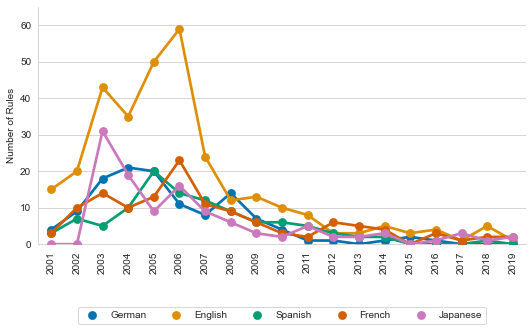

In [29]:
_melted = pd.melt(creation_by_year_df.fillna(0).reset_index(),id_vars=['index'],value_vars=_hue_order)
g = sb.factorplot(x='index',y='value',hue='variable',data=_melted,
                   legend=False,kind='point',hue_order=_hue_order,palette='colorblind',order=year_order,aspect=1.5)
g.set_xticklabels(rotation=90)
g.axes[0][0].set_xlabel('')
g.axes[0][0].set_ylabel('Number of Rules')
#g.axes[0][0].set_yscale('symlog')
g.axes[0][0].set_ylim((0,65))
plt.legend(loc='center',bbox_to_anchor=(0.5,-0.3),ncol=5)
plt.tight_layout()
plt.savefig('./figs/rules_by_year_created.pdf',dpi=300,bbox_inches='tight')
plt.savefig('./figs/rules_by_year_created.png',dpi=300,bbox_inches='tight')

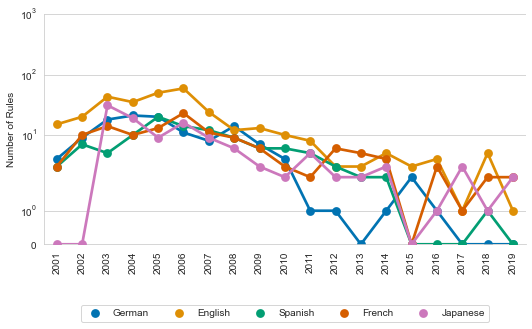

In [30]:
_melted = pd.melt(creation_by_year_df.fillna(0).reset_index(),id_vars=['index'],value_vars=_hue_order)
g = sb.factorplot(x='index',y='value',hue='variable',data=_melted,
                   legend=False,kind='point',hue_order=_hue_order,palette='colorblind',order=year_order,aspect=1.5)
g.set_xticklabels(rotation=90)
g.axes[0][0].set_xlabel('')
g.axes[0][0].set_ylabel('Number of Rules')
g.axes[0][0].set_yscale('symlog')
g.axes[0][0].set_ylim((0,1e3))
plt.legend(loc='center',bbox_to_anchor=(0.5,-0.3),ncol=5)
plt.tight_layout()
plt.savefig('./figs/rules_by_year_created_symlog.pdf',dpi=300,bbox_inches='tight')
plt.savefig('./figs/rules_by_year_created_symlog.png',dpi=300,bbox_inches='tight')

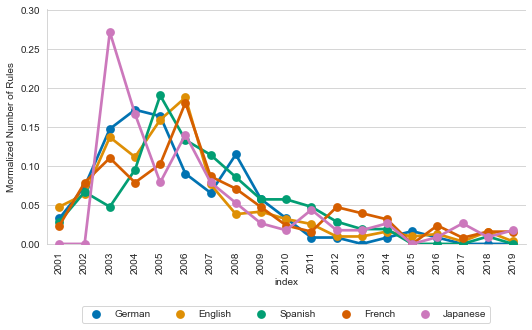

In [31]:
_melted = pd.melt(creation_by_year_df.fillna(0).div(creation_by_year_df.sum()).reset_index(),id_vars=['index'],value_vars=_hue_order)
g = sb.factorplot(x='index',y='value',hue='variable',data=_melted,legend=False,kind='point',
                   hue_order=_hue_order,palette='colorblind',order=year_order,aspect=1.5)
g.set_xticklabels(rotation=90)
#g.axes[0][0].set_xlabel('')
g.axes[0][0].set_ylabel('Mormalized Number of Rules')
g.axes[0][0].set_ylim((0,.301))
plt.legend(loc='center',bbox_to_anchor=(0.5,-0.3),ncol=5)
plt.tight_layout()
plt.savefig('./figs/rules_by_year_created_normalized.pdf',dpi=300,bbox_inches='tight')
plt.savefig('./figs/rules_by_year_created_normalized.png',dpi=300,bbox_inches='tight')

### Annual activity by year created

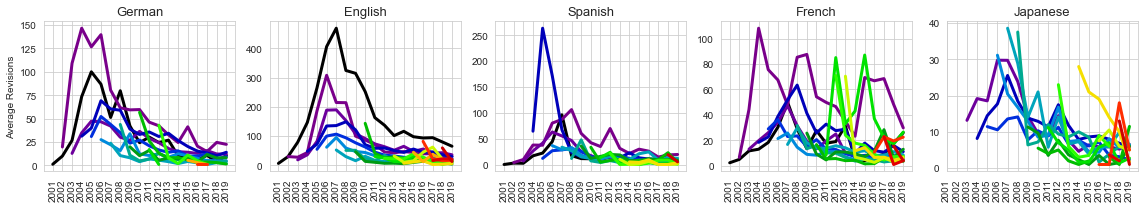

In [32]:
rev_df_list = [rev_df_de,rev_df_en,rev_df_es,rev_df_fr,rev_df_ja]
rev_df_names = ['German','English','Spanish','French','Japanese']

f,axs = plt.subplots(1,5,figsize=(16,3))

for i,(rev_df,name) in enumerate(zip(rev_df_list,rev_df_names)):
    _df = rev_df.groupby(['creation_year','page','year']).agg({'revid':len})['revid']
    _df = _df.mean(level=['creation_year','year']).unstack('creation_year')#.cumsum().fillna(method='ffill')
    _df = _df.reindex(columns=range(2001,2020))
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')

axs[0].set_ylabel('Average Revisions')
f.tight_layout()
f.savefig('./figs/annual_revisions_by_creation_year.pdf',dpi=300,bbox_inches='tight')
f.savefig('./figs/annual_revisions_by_creation_year.png',dpi=300,bbox_inches='tight')

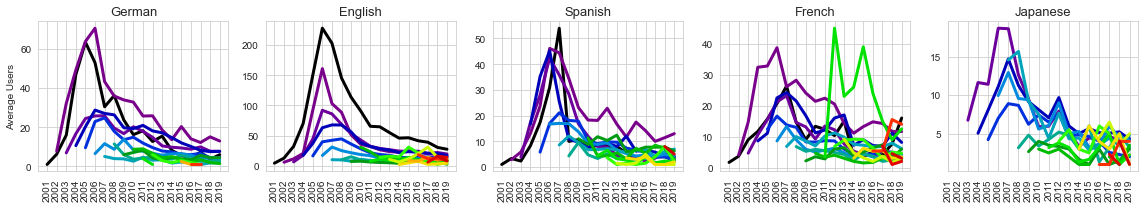

In [33]:
f,axs = plt.subplots(1,5,figsize=(16,3))

for i,(rev_df,name) in enumerate(zip(rev_df_list,rev_df_names)):
    _df = rev_df.groupby(['creation_year','page','year']).agg({'user':pd.Series.nunique})['user']
    _df = _df.mean(level=['creation_year','year']).unstack('creation_year')
    _df = _df.reindex(columns=range(2001,2020))
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')

axs[0].set_ylabel('Average Users')
f.tight_layout()
f.savefig('./figs/annual_users_by_creation_year.pdf',dpi=300,bbox_inches='tight')
f.savefig('./figs/annual_users_by_creation_year.png',dpi=300,bbox_inches='tight')

In [34]:
#print(rev_df_de.groupby(['creation_year','page','year']).agg({'size':np.mean})['size'].mean(level=['creation_year','year']).unstack('creation_year'))

rev_df_de[rev_df_de.creation_year == 2015].head()

,revid,parentid,user,userid,timestamp,size,sha1,comment,page,date,diff,lag,age,anon,sha1hidden,userhidden,commenthidden,suppressed,year,creation_year,user_start_year
191,147707961,0,Markscheider,53620,2015-11-04 16:45:11+00:00,5684,527a2784c960746914ab7a4c35806e35f8fcc73c,[[Hilfe:Zusammenfassung und Quellen#Auto-Zusam...,Portal:Bergbau/Namenskonventionen,2015-11-04,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,2015,2015,2010.0
192,147708456,147707961,Markscheider,53620,2015-11-04 17:04:07+00:00,5730,a24e57b89e5a526818dd54c9ab7944cf3e162719,/* Siehe auch */,Portal:Bergbau/Namenskonventionen,2015-11-04,46.0,1136.0,0.013148,NaN,NaN,NaN,NaN,NaN,2015,2015,2010.0
193,147711030,147708456,Agricolax,1812323,2015-11-04 18:39:40+00:00,5878,01fbf6b5d3ea7c2c41d2b43681af82129a8ce27f,Test Einbau auf Portalseite,Portal:Bergbau/Namenskonventionen,2015-11-04,148.0,5733.0,0.079502,NaN,NaN,NaN,NaN,NaN,2015,2015,2015.0
194,147711209,147711030,Agricolax,1812323,2015-11-04 18:46:09+00:00,5860,13e64c9382e6dbb51a390ec3a6f2e0cf2044c38a,NaN,Portal:Bergbau/Namenskonventionen,2015-11-04,-18.0,389.0,0.084005,NaN,NaN,NaN,NaN,NaN,2015,2015,2015.0
195,147711746,147711209,Agricolax,1812323,2015-11-04 19:03:00+00:00,5862,6f2cd9fde786e707bb8d715841bc0da9e0ca0861,Plural,Portal:Bergbau/Namenskonventionen,2015-11-04,2.0,1011.0,0.095706,NaN,NaN,NaN,NaN,NaN,2015,2015,2015.0


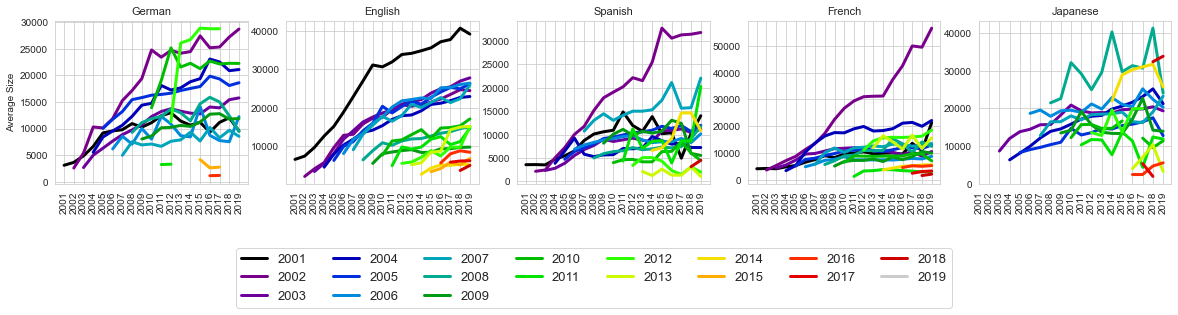

In [35]:
rev_df_list = [rev_df_de,rev_df_en,rev_df_es,rev_df_fr,rev_df_ja]
rev_df_names = ['German','English','Spanish','French','Japanese']

f,axs = plt.subplots(1,5,figsize=(20,3))

for i,(rev_df,name) in enumerate(zip(rev_df_list,rev_df_names)):
    _df = rev_df.groupby(['creation_year','page','year']).agg({'size':np.mean})['size']
    _df = _df.mean(level=['creation_year','year']).unstack('creation_year')#.cumsum().fillna(method='ffill')
    _df = _df.reindex(columns=range(2001,2020))
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=11)
    axs[i].set_xlabel('')

axs[-1].legend(loc='lower center',bbox_to_anchor=(-2,-.8),ncol=8,fontsize=13)
axs[0].set_ylabel('Average Size')
f.tight_layout()
#f.suptitle('Average annual size of rules, by year of creation\n\n\n\n',fontsize=15)
f.savefig('./figs/annualavgsize_size_by_creation_year.pdf',dpi=300,bbox_inches='tight')
f.savefig('./figs/annualavgsize_size_by_creation_year.png',dpi=300,bbox_inches='tight')

In [36]:
talkrev_df_list = [talkrev_df_de,talkrev_df_en,talkrev_df_es,talkrev_df_fr,talkrev_df_ja]
['diff' in _df.columns for _df in talkrev_df_list]

[True, True, True, True, True]

Text(0, 0.5, 'Cumulative Revisions to talk pages')

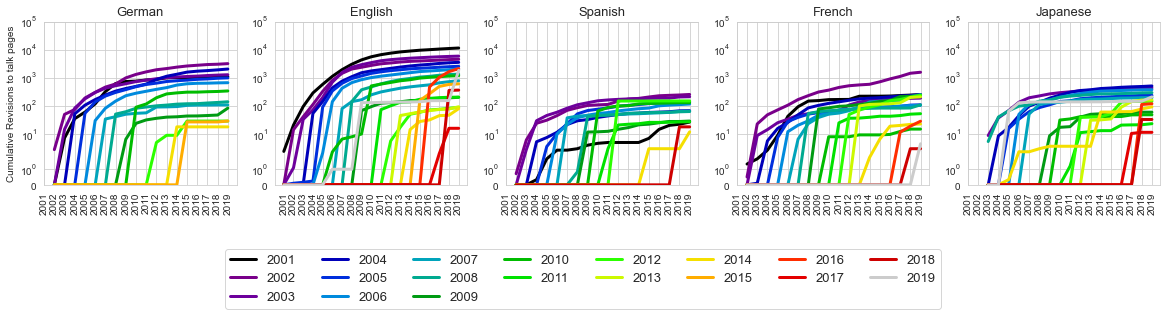

In [37]:
f,axs = plt.subplots(1,5,figsize=(20,3))

for i,(rev_df,name) in enumerate(zip(talkrev_df_list,rev_df_names)):
    _df = rev_df.groupby(['creation_year','page','year']).agg({'revid':pd.Series.nunique})['revid'].unstack('year').fillna(0).cumsum(1).stack()
    _df = _df.mean(level=['creation_year','year']).unstack('creation_year')
    _df = _df.reindex(columns=range(2001,2020)).sort_index()
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=13)
    axs[i].set_ylim((0,1e5))
    axs[i].set_yscale('symlog')
    axs[i].set_xlabel('')

axs[-1].legend(loc='lower center',bbox_to_anchor=(-2,-.8),ncol=8,fontsize=13)
axs[0].set_ylabel('Cumulative Revisions to talk pages')

### Activity by year

In [38]:
# talkrev_df_list = [talkrev_df_de,talkrev_df_en,talkrev_df_es,talkrev_df_fr,talkrev_df_ja]
# rev_df_list = [rev_df_de,rev_df_en,rev_df_es,rev_df_fr,rev_df_ja]

activity_by_year_df_de = pd.DataFrame()
activity_by_year_df_de['Rule activity'] = rev_df_de.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_de['Rule median diff'] = rev_df_de.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_de['Rule median latency'] = rev_df_de.groupby(['year']).agg({'lag':np.median})['lag']
activity_by_year_df_de['Rule talk activity'] = talkrev_df_de.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_de['Rule talk median diff'] = talkrev_df_de.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_de['Rule talk median latency'] = talkrev_df_de.groupby(['year']).agg({'lag':np.median})['lag']

activity_by_year_df_en = pd.DataFrame()
activity_by_year_df_en['Rule activity'] = rev_df_en.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_en['Rule median diff'] = rev_df_en.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_en['Rule median latency'] = rev_df_en.groupby(['year']).agg({'lag':np.median})['lag']
activity_by_year_df_en['Rule talk activity'] = talkrev_df_en.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_en['Rule talk median diff'] = talkrev_df_en.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_en['Rule talk median latency'] = talkrev_df_en.groupby(['year']).agg({'lag':np.median})['lag']

activity_by_year_df_es = pd.DataFrame()
activity_by_year_df_es['Rule activity'] = rev_df_es.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_es['Rule median diff'] = rev_df_es.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_es['Rule median latency'] = rev_df_es.groupby(['year']).agg({'lag':np.median})['lag']
activity_by_year_df_es['Rule talk activity'] = talkrev_df_es.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_es['Rule talk median diff'] = talkrev_df_es.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_es['Rule talk median latency'] = talkrev_df_es.groupby(['year']).agg({'lag':np.median})['lag']

activity_by_year_df_fr = pd.DataFrame()
activity_by_year_df_fr['Rule activity'] = rev_df_fr.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_fr['Rule median diff'] = rev_df_fr.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_fr['Rule median latency'] = rev_df_fr.groupby(['year']).agg({'lag':np.median})['lag']
activity_by_year_df_fr['Rule talk activity'] = talkrev_df_fr.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_fr['Rule talk median diff'] = talkrev_df_fr.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_fr['Rule talk median latency'] = talkrev_df_fr.groupby(['year']).agg({'lag':np.median})['lag']

activity_by_year_df_ja = pd.DataFrame()
activity_by_year_df_ja['Rule activity'] = rev_df_ja.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_ja['Rule median diff'] = rev_df_ja.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_ja['Rule median latency'] = rev_df_ja.groupby(['year']).agg({'lag':np.median})['lag']
activity_by_year_df_ja['Rule talk activity'] = talkrev_df_ja.groupby(['year']).agg({'revid':len})['revid']
activity_by_year_df_ja['Rule talk median diff'] = talkrev_df_ja.groupby(['year']).agg({'diff':np.median})['diff']
activity_by_year_df_ja['Rule talk median latency'] = talkrev_df_ja.groupby(['year']).agg({'lag':np.median})['lag']

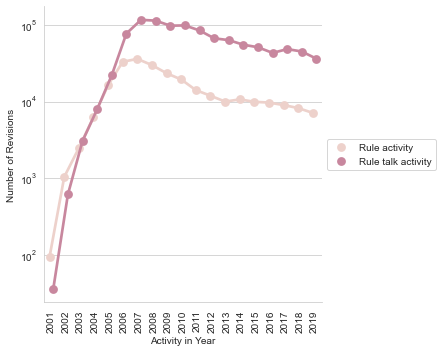

In [39]:
_melted = pd.melt(activity_by_year_df_en.reset_index(),id_vars=['year'],value_vars=['Rule activity','Rule talk activity'])

g = sb.factorplot(x='year',y='value',hue='variable',kind='point',data=_melted,legend=False,dodge=.25,
#                  linestyles=['-','--'],palette=sb.color_palette(['blue', 'blue']),aspect=1.25,order=year_order)
                   palette=sb.cubehelix_palette(4),aspect=1.25,order=year_order)
g.set_xticklabels(rotation=90)
g.axes[0][0].set_xlabel('Activity in Year')
g.axes[0][0].set_ylabel('Number of Revisions')
#g.axes[0][0].set_title('Policy and Talk Revision Activity by Year\n',fontsize=15)
g.axes[0][0].set_yscale('log')
plt.legend(loc='center left',bbox_to_anchor=(1,.5))
plt.tight_layout()
#plt.savefig('./figs/policy_activity_by_year_en.pdf',dpi=300,bbox_inches='tight')

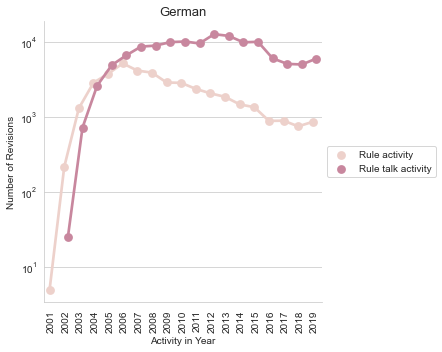

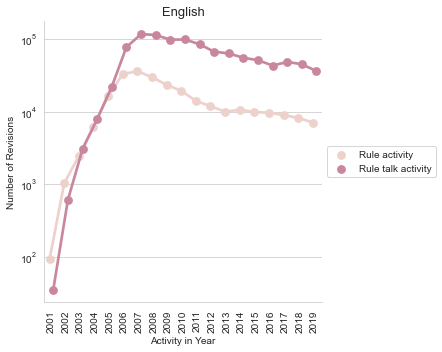

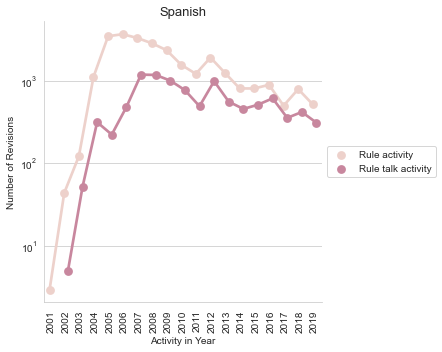

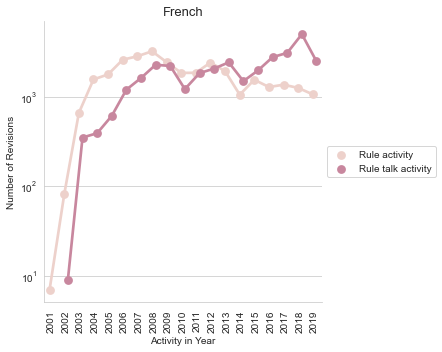

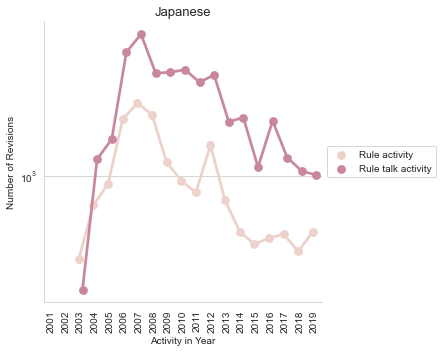

In [40]:
# do for all language editions

_activitybyyears = [activity_by_year_df_de,activity_by_year_df_en,activity_by_year_df_es,activity_by_year_df_fr,activity_by_year_df_ja]
_names = ['de','en','es','fr','ja']
# rev_df_names = ['German','English','Spanish','French','Japanese']

for i,langdf in enumerate(_activitybyyears):
    _melted = pd.melt(langdf.reset_index(),id_vars=['year'],value_vars=['Rule activity','Rule talk activity'])

    g = sb.factorplot(x='year',y='value',hue='variable',kind='point',data=_melted,legend=False,dodge=.25,
                    palette=sb.cubehelix_palette(4),aspect=1.25,order=year_order)
    g.set_xticklabels(rotation=90)
    g.axes[0][0].set_title(rev_df_names[i],fontsize=13)
    g.axes[0][0].set_xlabel('Activity in Year')
    g.axes[0][0].set_ylabel('Number of Revisions')
    g.axes[0][0].set_yscale('log')
    plt.legend(loc='center left',bbox_to_anchor=(1,.5))
    plt.tight_layout()
    plt.savefig('./figs/rule_activity_by_year_{}.pdf'.format(_names[i]),dpi=300,bbox_inches='tight')
    plt.savefig('./figs/rule_activity_by_year_{}.png'.format(_names[i]),dpi=300,bbox_inches='tight')


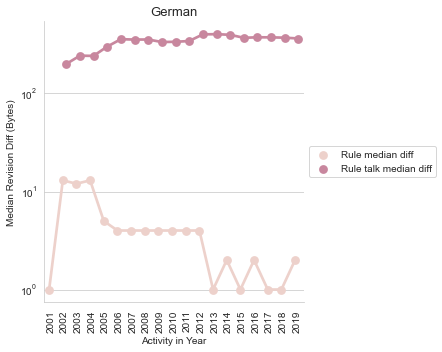

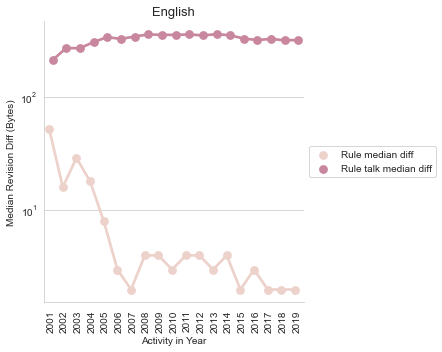

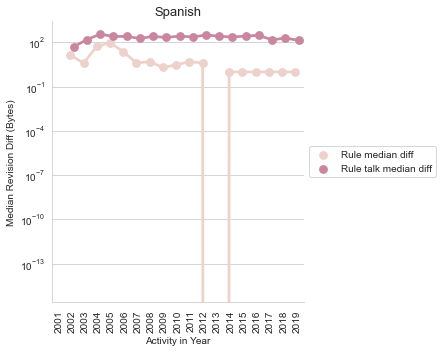

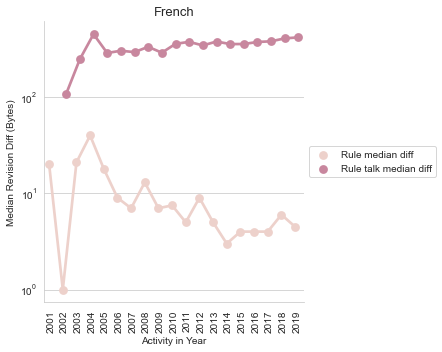

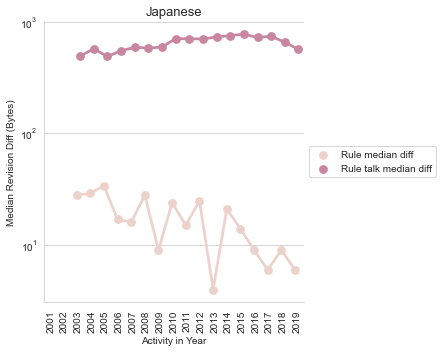

In [41]:
for i,langdf in enumerate(_activitybyyears):
    _melted = pd.melt(langdf.reset_index(),id_vars=['year'],value_vars=['Rule median diff','Rule talk median diff'])

    g = sb.factorplot(x='year',y='value',hue='variable',kind='point',data=_melted,legend=False,dodge=.25,
                    palette=sb.cubehelix_palette(4),aspect=1.25,order=year_order)
    g.set_xticklabels(rotation=90)
    g.axes[0][0].set_title(rev_df_names[i],fontsize=13)
    g.axes[0][0].set_xlabel('Activity in Year')
    g.axes[0][0].set_ylabel('Median Revision Diff (Bytes)')
    g.axes[0][0].set_yscale('log')
    plt.legend(loc='center left',bbox_to_anchor=(1,.5))
    plt.tight_layout()
    plt.savefig('./figs/rule_media_diff_by_year_{}.pdf'.format(_names[i]),dpi=300,bbox_inches='tight')
    plt.savefig('./figs/rule_media_diff_by_year_{}.png'.format(_names[i]),dpi=300,bbox_inches='tight')


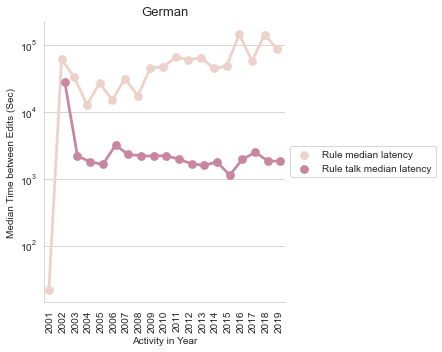

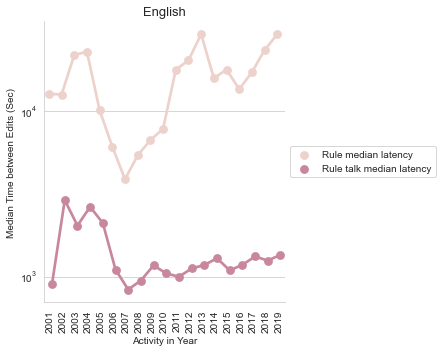

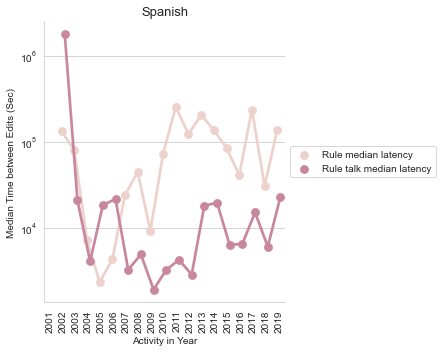

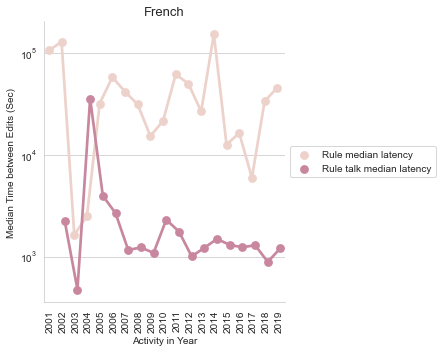

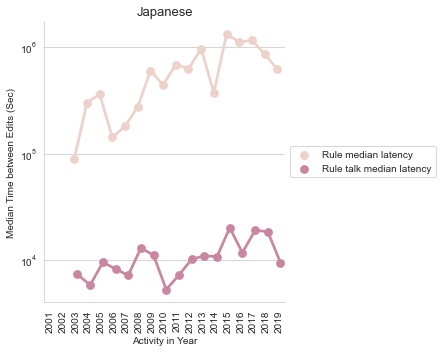

In [42]:
for i,langdf in enumerate(_activitybyyears):
    _melted = pd.melt(langdf.reset_index(),id_vars=['year'],value_vars=['Rule median latency','Rule talk median latency'])

    g = sb.factorplot(x='year',y='value',hue='variable',kind='point',data=_melted,legend=False,dodge=.25,
                    palette=sb.cubehelix_palette(4),aspect=1.25,order=year_order)
    g.set_xticklabels(rotation=90)
    g.axes[0][0].set_title(rev_df_names[i],fontsize=13)
    g.axes[0][0].set_xlabel('Activity in Year')
    g.axes[0][0].set_ylabel('Median Time between Edits (Sec)')
    g.axes[0][0].set_yscale('log')
    plt.legend(loc='center left',bbox_to_anchor=(1,.5))
    plt.tight_layout()
    plt.savefig('./figs/rule_median_latency_by_year_{}.pdf'.format(_names[i]),dpi=300,bbox_inches='tight')
    plt.savefig('./figs/rule_median_latency_by_year_{}.png'.format(_names[i]),dpi=300,bbox_inches='tight')

In [43]:
activity_by_year_df_alllangs = pd.concat([activity_by_year_df_de,activity_by_year_df_en,activity_by_year_df_es,activity_by_year_df_fr,activity_by_year_df_ja],names=['lang'],keys=['German','English','Spanish','French','Japanese']).reset_index()

activity_by_year_df_alllangs.head()

,lang,year,Rule activity,Rule median diff,Rule median latency,Rule talk activity,Rule talk median diff,Rule talk median latency
0,German,2001.0,5,1.0,22.0,NaN,NaN,NaN
1,German,2002.0,217,13.0,61029.0,25.0,200.0,28134.0
2,German,2003.0,1320,12.0,32921.5,728.0,243.0,2197.5
3,German,2004.0,2895,13.0,12787.5,2641.0,242.0,1792.0
4,German,2005.0,3805,5.0,26931.0,4969.0,301.0,1635.0


## User as unit of analysis
Fiegan 2017 RQ2 figures

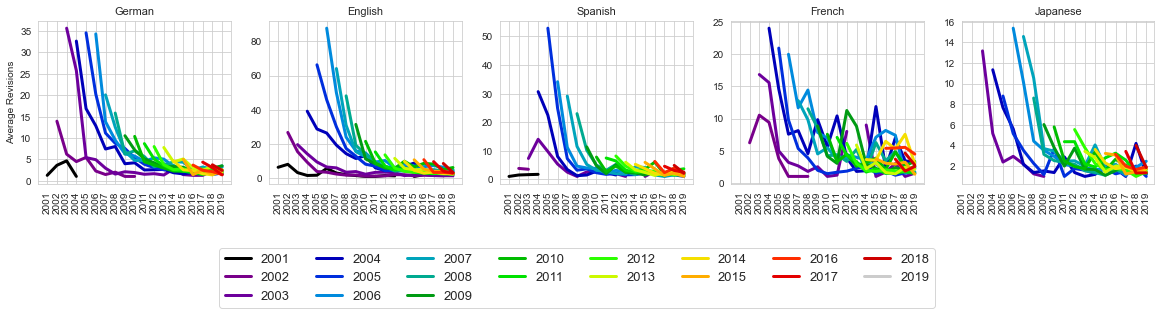

In [44]:
rev_df_list = [rev_df_de,rev_df_en,rev_df_es,rev_df_fr,rev_df_ja]
rev_df_names = ['German','English','Spanish','French','Japanese']

f,axs = plt.subplots(1,5,figsize=(20,3))

for i,(rev_df,name) in enumerate(zip(rev_df_list,rev_df_names)):
    _df = rev_df.groupby(['user_start_year','page','year']).agg({'revid':len})['revid']
    _df = _df.mean(level=['user_start_year','year']).unstack('user_start_year')#.cumsum().fillna(method='ffill')
    _df = _df.reindex(columns=range(2001,2020))
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=11)
    axs[i].set_xlabel('')

axs[-1].legend(loc='lower center',bbox_to_anchor=(-2,-.8),ncol=8,fontsize=13)
axs[0].set_ylabel('Average Revisions')
f.tight_layout()
f.savefig('./figs/annual_revisions_by_user_start_year.pdf',dpi=300,bbox_inches='tight')
f.savefig('./figs/annual_revisions_by_user_start_year.png',dpi=300,bbox_inches='tight')

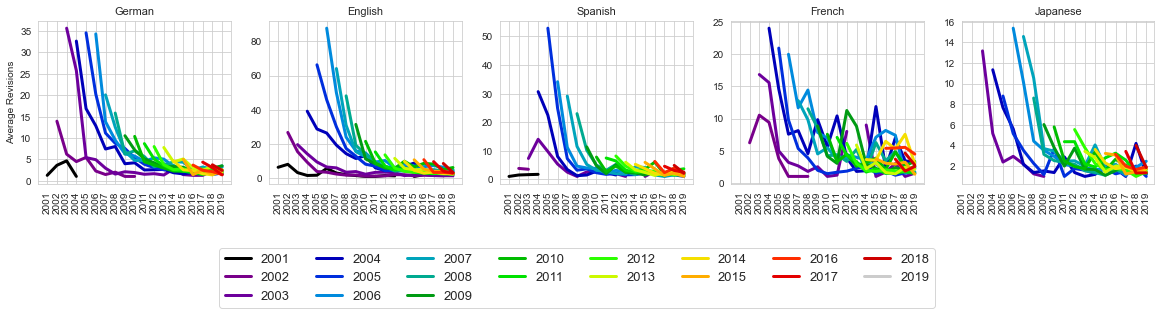

In [46]:
f,axs = plt.subplots(1,5,figsize=(20,3))

for i,(rev_df,name) in enumerate(zip(rev_df_list,rev_df_names)):
    _df = rev_df.groupby(['user_start_year','page','year']).agg({'revid':len})['revid']
    _df = _df.mean(level=['user_start_year','year']).unstack('user_start_year')#.cumsum().fillna(method='ffill')
    _df = _df.reindex(columns=range(2001,2020))
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=11)
    axs[i].set_xlabel('')

axs[-1].legend(loc='lower center',bbox_to_anchor=(-2,-.8),ncol=8,fontsize=13)
axs[0].set_ylabel('Average Revisions')
f.tight_layout()
f.savefig('./figs/annual_talk_revisions_by_user_start_year.pdf',dpi=300,bbox_inches='tight')
f.savefig('./figs/annual_talk_revisions_by_user_start_year.png',dpi=300,bbox_inches='tight')

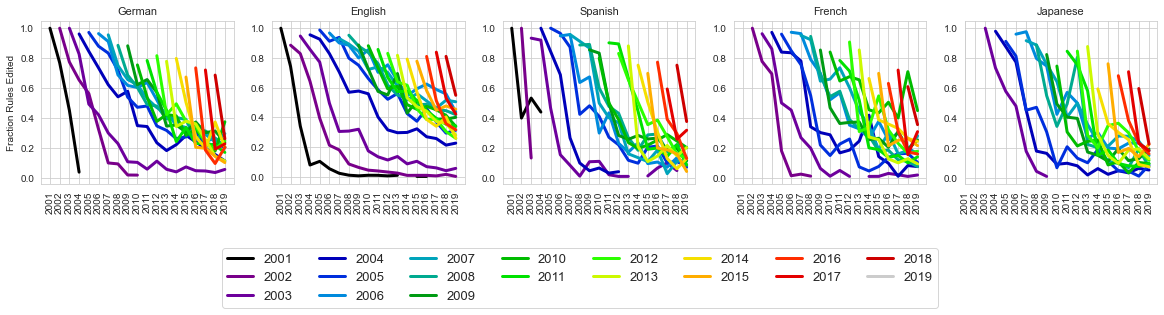

In [45]:
annual_counts_de = rev_df_de.groupby(['year']).agg({'page':pd.Series.nunique})['page']
annual_counts_en = rev_df_en.groupby(['year']).agg({'page':pd.Series.nunique})['page']
annual_counts_es = rev_df_es.groupby(['year']).agg({'page':pd.Series.nunique})['page']
annual_counts_fr = rev_df_fr.groupby(['year']).agg({'page':pd.Series.nunique})['page']
annual_counts_ja = rev_df_ja.groupby(['year']).agg({'page':pd.Series.nunique})['page']
annual_counts = [annual_counts_de,annual_counts_en,annual_counts_es,annual_counts_fr,annual_counts_ja]

f,axs = plt.subplots(1,5,figsize=(20,3))

for i,(rev_df,name) in enumerate(zip(rev_df_list,rev_df_names)):
    _df = rev_df.groupby(['user_start_year','year']).agg({'page':pd.Series.nunique})['page'].unstack('user_start_year')
    _df = _df.reindex(columns=range(2001,2020)).div(annual_counts[i],0)
    _df.plot(lw=3,legend=False,cmap='nipy_spectral',ax=axs[i])
    axs[i].set_xticks(range(2001,2020))
    axs[i].set_xticklabels(range(2001,2020),rotation=90)
    axs[i].set_title(name,fontsize=11)
    axs[i].set_xlabel('')

axs[-1].legend(loc='lower center',bbox_to_anchor=(-2,-.8),ncol=8,fontsize=13)
axs[0].set_ylabel('Fraction Rules Edited')
f.tight_layout()
f.savefig('./figs/fractionrules_edited_by_user_start_year.pdf',dpi=300,bbox_inches='tight')
f.savefig('./figs/fractionrules_edited_by_user_start_year.png',dpi=300,bbox_inches='tight')

In [47]:
#jaccard?

## Interlanguage links